In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates 
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import imageio
import os
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd
import glob 

# 1. EDA
## 1.1. Tạo DataFrame Dataset 

In [2]:
list_csv_data  = []

location_input_data = pd.read_csv("data-train/location_input.csv", index_col=0)
station_list = []

for csv_path in glob.glob("data-train/input/*"):
    csv_data = pd.read_csv(csv_path, index_col=0, parse_dates=['timestamp'], dayfirst=True)
    station = csv_path.split("/")[-1].split('\\')[-1].split(".")[0]
    station_list.append(station)
    csv_data["station"] = station

    # Add location (longitude, latitude) to data 
    csv_data["longitude"] = location_input_data[location_input_data["station"] == station]["longitude"].to_string(index=False)
    csv_data["latitude"] = location_input_data[location_input_data["station"] == station]["latitude"].to_string(index=False)

    # Convert timestamp to datetime
    csv_data["timestamp"] = pd.to_datetime(csv_data["timestamp"], format='%d/%m/%y %H:%M')
    list_csv_data.append(csv_data)

all_input_data = pd.concat(list_csv_data, ignore_index=True)

In [3]:
all_input_data.head(10)

,timestamp,PM2.5,humidity,temperature,station,longitude,latitude
0,2020-05-27 12:00:00,23.66,64.09,29.96,S0000137-Ngoc Khanh,105.812642,21.026052
1,2020-05-27 13:00:00,23.08,63.05,30.07,S0000137-Ngoc Khanh,105.812642,21.026052
2,2020-05-27 14:00:00,25.68,67.51,29.77,S0000137-Ngoc Khanh,105.812642,21.026052
3,2020-05-27 15:00:00,26.37,71.17,29.11,S0000137-Ngoc Khanh,105.812642,21.026052
4,2020-05-27 16:00:00,27.57,71.60,29.08,S0000137-Ngoc Khanh,105.812642,21.026052
5,2020-05-27 17:00:00,29.43,74.35,28.59,S0000137-Ngoc Khanh,105.812642,21.026052
6,2020-05-27 18:00:00,32.72,75.46,28.48,S0000137-Ngoc Khanh,105.812642,21.026052
7,2020-05-27 19:00:00,32.56,75.69,28.09,S0000137-Ngoc Khanh,105.812642,21.026052
8,2020-05-27 20:00:00,32.33,76.60,27.80,S0000137-Ngoc Khanh,105.812642,21.026052
9,2020-05-27 21:00:00,34.33,76.48,27.74,S0000137-Ngoc Khanh,105.812642,21.026052


In [4]:
all_input_data.describe()

,PM2.5,humidity,temperature
count,82921.000000,83088.000000,83341.000000
mean,44.682972,76.065066,26.594974
std,41.425499,15.463777,5.931635
min,0.550000,9.050000,8.800000
25%,20.300000,65.700000,22.400000
50%,30.400000,77.900000,27.100000
75%,53.900000,87.660000,30.700000
max,270.000000,100.000000,45.910000


In [5]:
all_input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99000 entries, 0 to 98999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    99000 non-null  datetime64[ns]
 1   PM2.5        82921 non-null  float64       
 2   humidity     83088 non-null  float64       
 3   temperature  83341 non-null  float64       
 4   station      99000 non-null  object        
 5   longitude    99000 non-null  object        
 6   latitude     99000 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 5.3+ MB


=> Cột PM2.5, humidity và temprature có giá trị thiếu.
### 1.1.1. Tạo dataframe cho từng trạm

In [6]:
df_NgocKhanh = all_input_data[all_input_data['station']== 'S0000137-Ngoc Khanh']
df_ThuVien = all_input_data[all_input_data['station']== 'S0000143-Thu vien - DHQG Ha Noi']
df_TranQuocToan  = all_input_data[all_input_data['station']== 'S0000153-Truong Tieu hoc Tran Quoc Toan']
df_Genesis = all_input_data[all_input_data['station']== 'S0000171-GENESIS School']
df_YenSo = all_input_data[all_input_data['station']== 'S0000210-Truong THCS Yen So']
df_QuanHoa = all_input_data[all_input_data['station']== 'S0000229-Quan Hoa']
df_Lomonoxop = all_input_data[all_input_data['station']== 'S0000238-He thong lien cap Lomonoxop - Mam non']
df_TonThatThuyet = all_input_data[all_input_data['station']== 'S0000264-FDS - Ton That Thuyet']
df_HangTrong = all_input_data[all_input_data['station']== 'S0000310-Hang Trong']
df_BaTrieu = all_input_data[all_input_data['station']== 'S0000370-Ba Trieu']

### 1.1.2. Sort dataframe

In [7]:
sorted_timestamp_df = all_input_data.sort_values(by=['timestamp'])

## 1.2. Tiền xử lý 
### 1.2.1. Tìm vị trí các giá trị thiếu

In [8]:
import missingno as msno

def missing_values_table(df):
    """This function prints out a table of missing values of the dataframe.
    """
    # Total missing values
    mis_val = df.isnull().sum()
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    # Print some summary information
    station_name = df["station"].unique()[0]
    print(f"Data của trạm {station_name}")
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [9]:
missing_values= missing_values_table(df_NgocKhanh)
missing_values.style.background_gradient(cmap='Reds')

Data của trạm S0000137-Ngoc Khanh


,Missing Values,% of Total Values
PM2.5,897,10.000000
humidity,681,7.600000
temperature,681,7.600000


<AxesSubplot:>

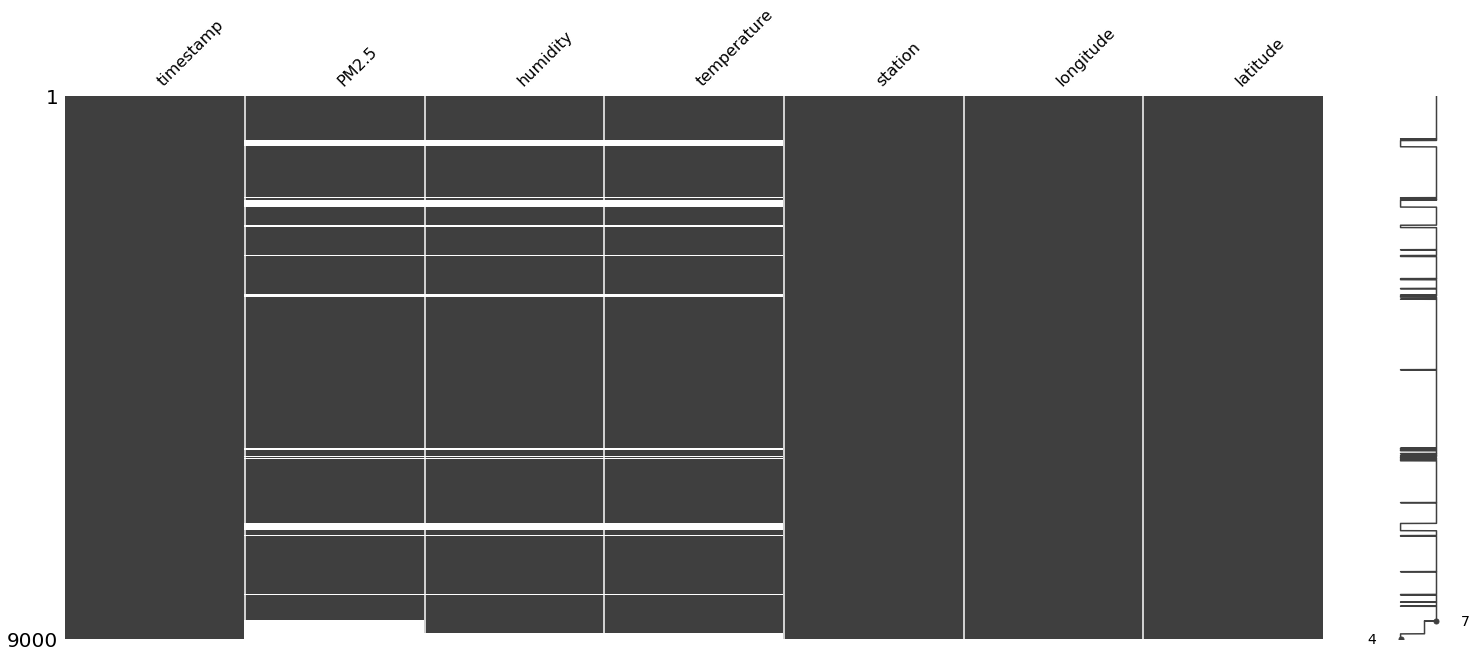

In [10]:
sorted_timestamp_df_NgocKhanh = df_NgocKhanh.sort_values(by=['timestamp'])
msno.matrix(sorted_timestamp_df_NgocKhanh)

In [11]:
missing_values= missing_values_table(df_ThuVien)
missing_values.style.background_gradient(cmap='Reds')

Data của trạm S0000143-Thu vien - DHQG Ha Noi


,Missing Values,% of Total Values
humidity,2492,27.700000
temperature,2492,27.700000
PM2.5,2451,27.200000


<AxesSubplot:>

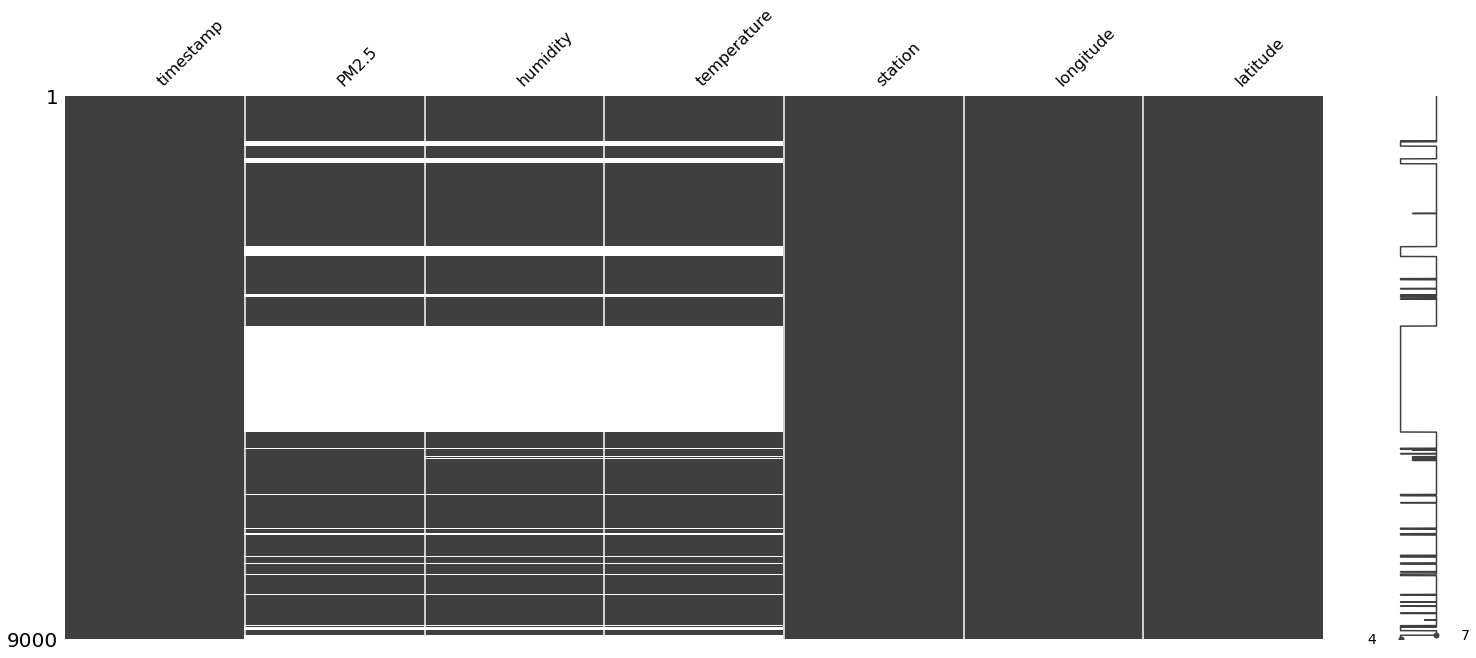

In [12]:
sorted_timestamp_df_ThuVien = df_ThuVien.sort_values(by=['timestamp'])
msno.matrix(sorted_timestamp_df_ThuVien)

In [13]:
missing_values= missing_values_table(df_TranQuocToan)
missing_values.style.background_gradient(cmap='Reds')

Data của trạm S0000153-Truong Tieu hoc Tran Quoc Toan


,Missing Values,% of Total Values
humidity,985,10.900000
temperature,985,10.900000
PM2.5,984,10.900000


<AxesSubplot:>

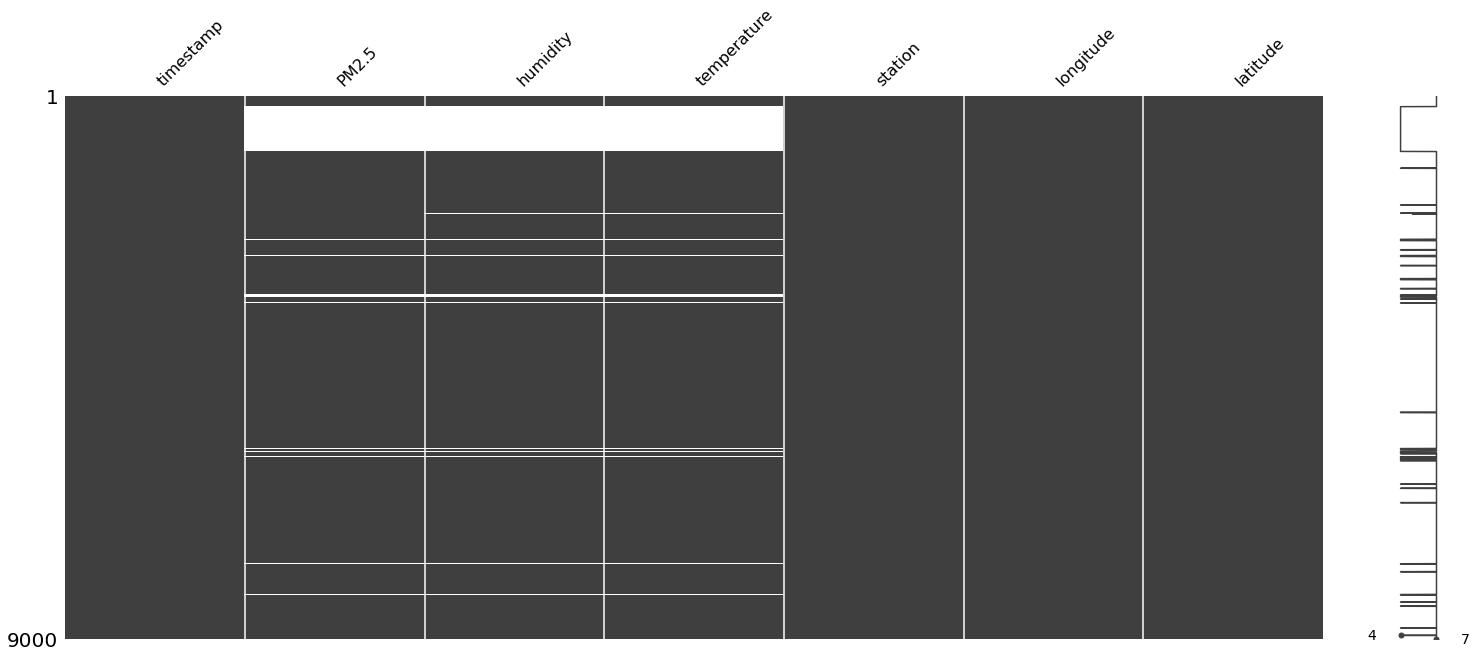

In [14]:
sorted_timestamp_df_TranQuocToan = df_TranQuocToan.sort_values(by=['timestamp'])
msno.matrix(sorted_timestamp_df_TranQuocToan)

In [15]:
missing_values= missing_values_table(df_Genesis)
missing_values.style.background_gradient(cmap='Reds')

Data của trạm S0000171-GENESIS School


,Missing Values,% of Total Values
PM2.5,3326,37.000000
humidity,3325,36.900000
temperature,3325,36.900000


<AxesSubplot:>

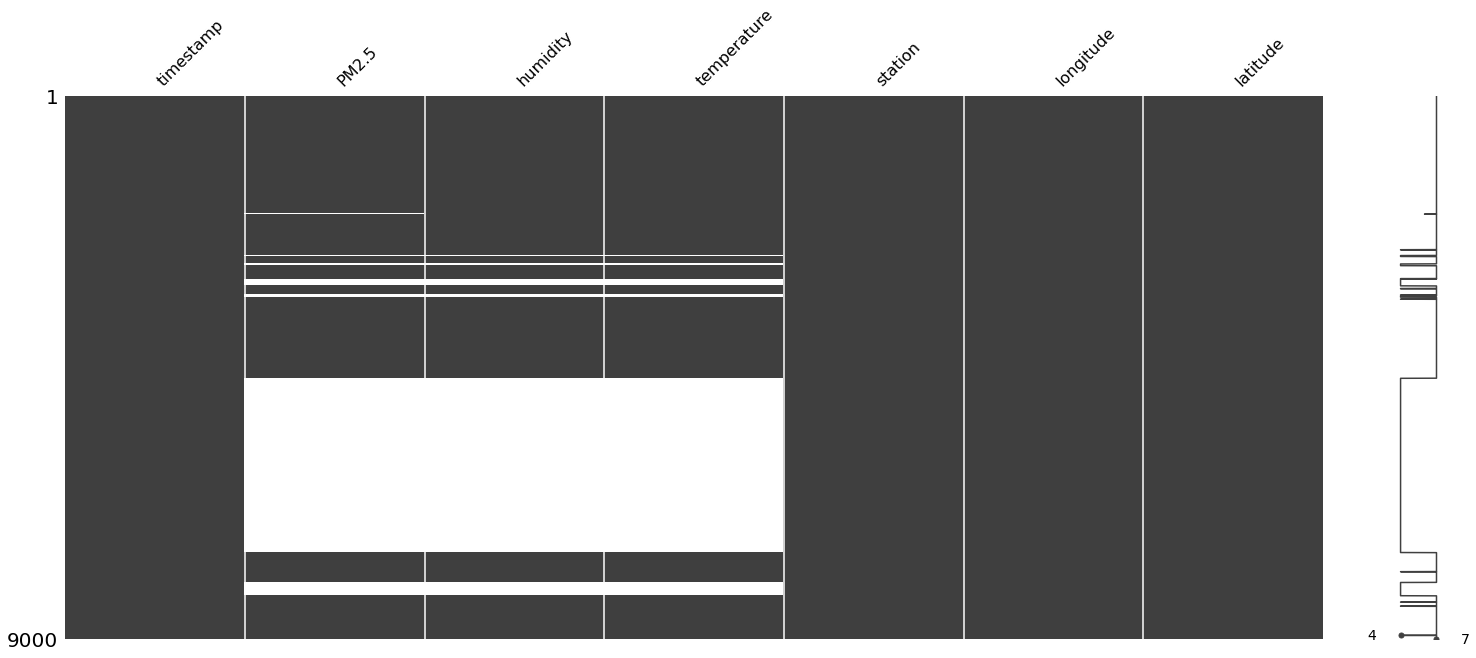

In [16]:
sorted_timestamp_df_Genesis = df_Genesis.sort_values(by=['timestamp'])
msno.matrix(sorted_timestamp_df_Genesis)

In [17]:
missing_values= missing_values_table(df_YenSo)
missing_values.style.background_gradient(cmap='Reds')

Data của trạm S0000210-Truong THCS Yen So


,Missing Values,% of Total Values
PM2.5,475,5.300000
humidity,472,5.200000
temperature,472,5.200000


<AxesSubplot:>

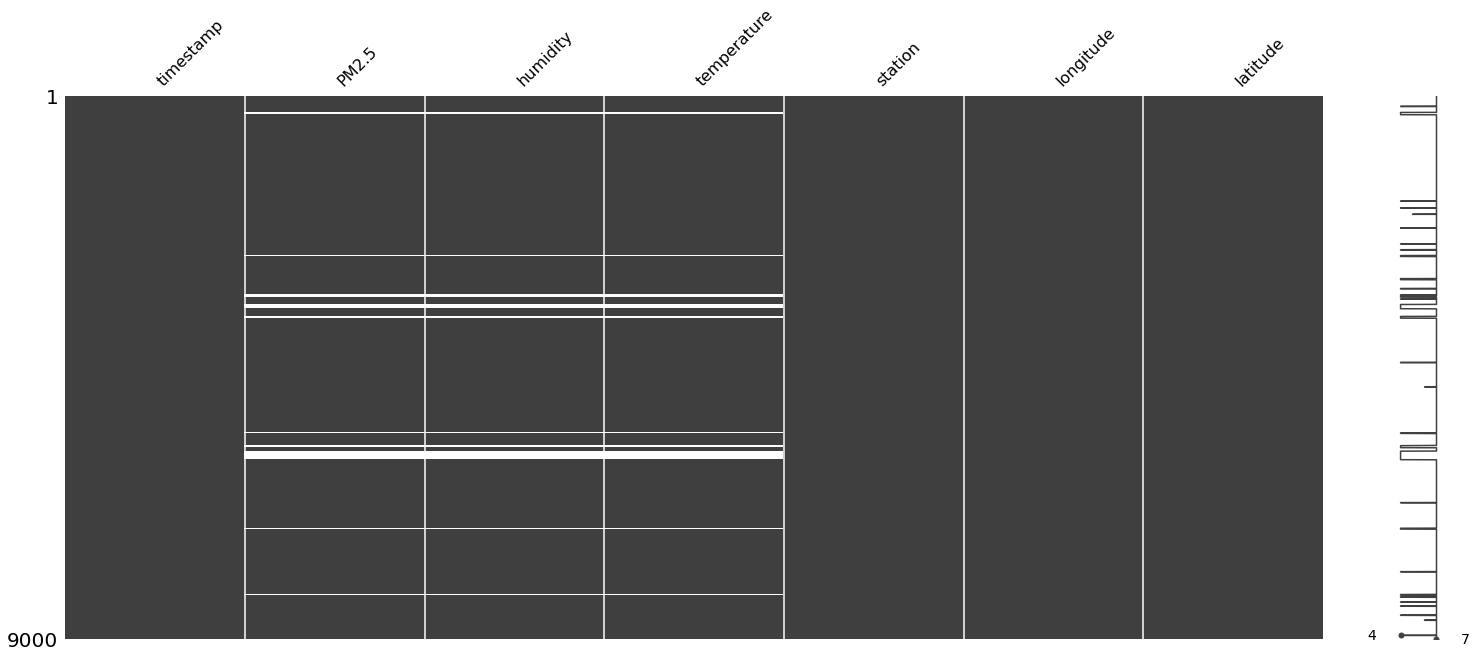

In [18]:
sorted_timestamp_df_YenSo = df_YenSo.sort_values(by=['timestamp'])
msno.matrix(sorted_timestamp_df_YenSo)

In [19]:
missing_values= missing_values_table(df_QuanHoa)
missing_values.style.background_gradient(cmap='Reds')

Data của trạm S0000229-Quan Hoa


,Missing Values,% of Total Values
humidity,480,5.300000
temperature,480,5.300000
PM2.5,479,5.300000


<AxesSubplot:>

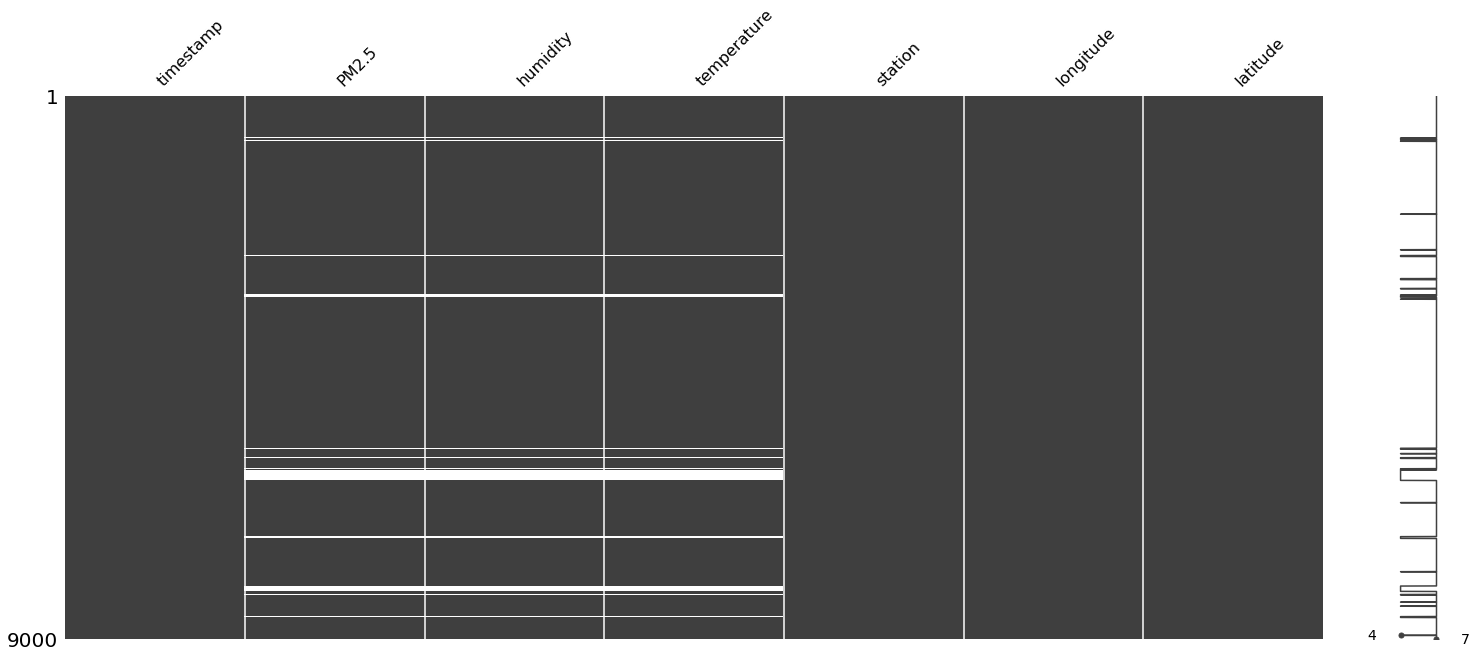

In [20]:
sorted_timestamp_df_QuanHoa = df_QuanHoa.sort_values(by=['timestamp'])
msno.matrix(sorted_timestamp_df_QuanHoa)

In [21]:
missing_values= missing_values_table(df_Lomonoxop)
missing_values.style.background_gradient(cmap='Reds')

Data của trạm S0000238-He thong lien cap Lomonoxop - Mam non


,Missing Values,% of Total Values
PM2.5,589,6.500000
temperature,248,2.800000
humidity,247,2.700000


<AxesSubplot:>

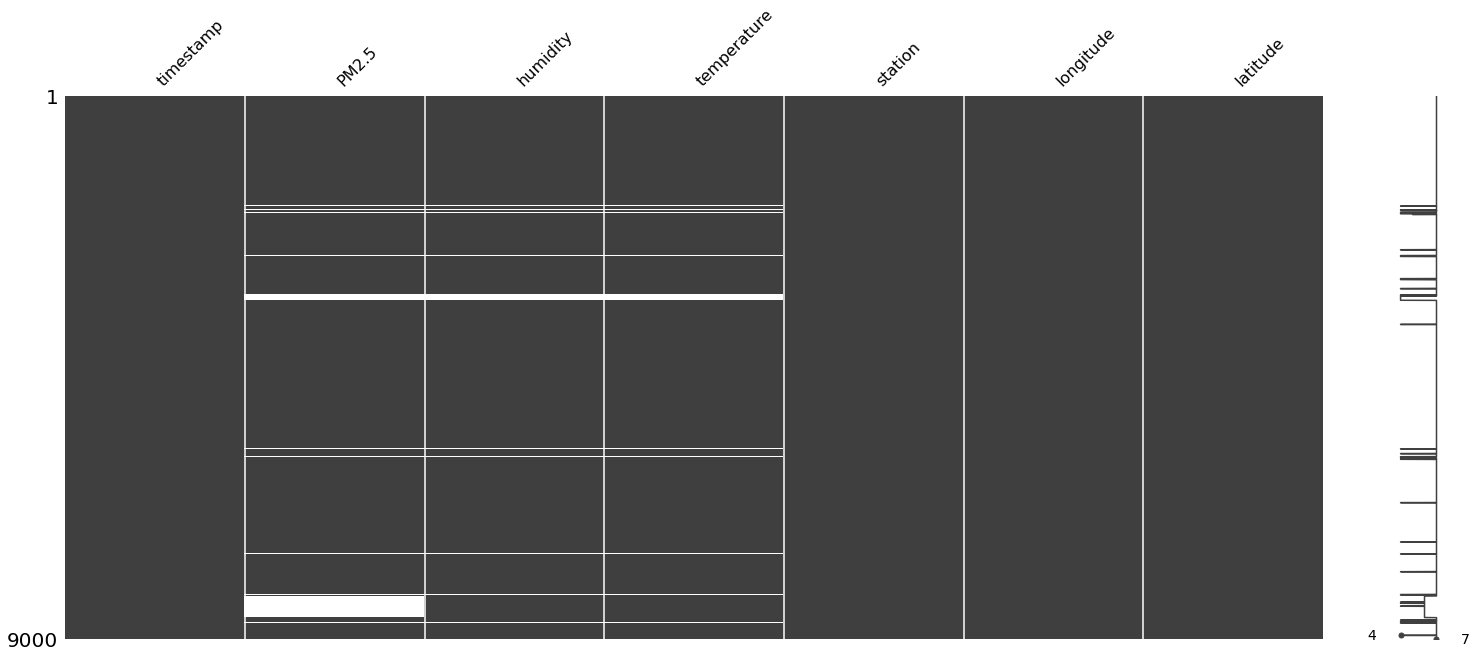

In [22]:
sorted_timestamp_df_Lomonoxop = df_Lomonoxop.sort_values(by=['timestamp'])
msno.matrix(sorted_timestamp_df_Lomonoxop)

In [23]:
missing_values= missing_values_table(df_TonThatThuyet)
missing_values.style.background_gradient(cmap='Reds')

Data của trạm S0000264-FDS - Ton That Thuyet


,Missing Values,% of Total Values
humidity,2166,24.100000
temperature,2165,24.100000
PM2.5,2163,24.000000


<AxesSubplot:>

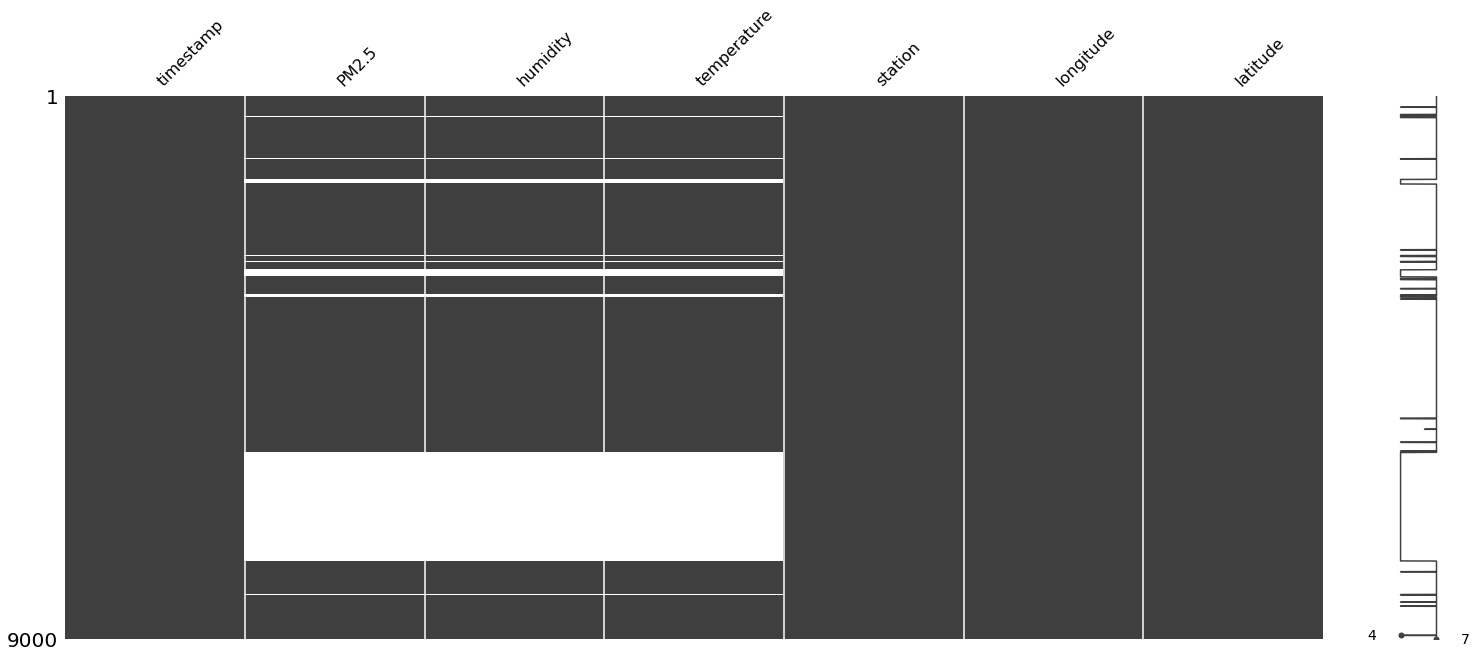

In [24]:
sorted_timestamp_df_TonThatThuyet = df_TonThatThuyet.sort_values(by=['timestamp'])
msno.matrix(sorted_timestamp_df_TonThatThuyet)

In [25]:
missing_values= missing_values_table(df_HangTrong)
missing_values.style.background_gradient(cmap='Reds')

Data của trạm S0000310-Hang Trong


,Missing Values,% of Total Values
humidity,633,7.000000
temperature,633,7.000000
PM2.5,591,6.600000


<AxesSubplot:>

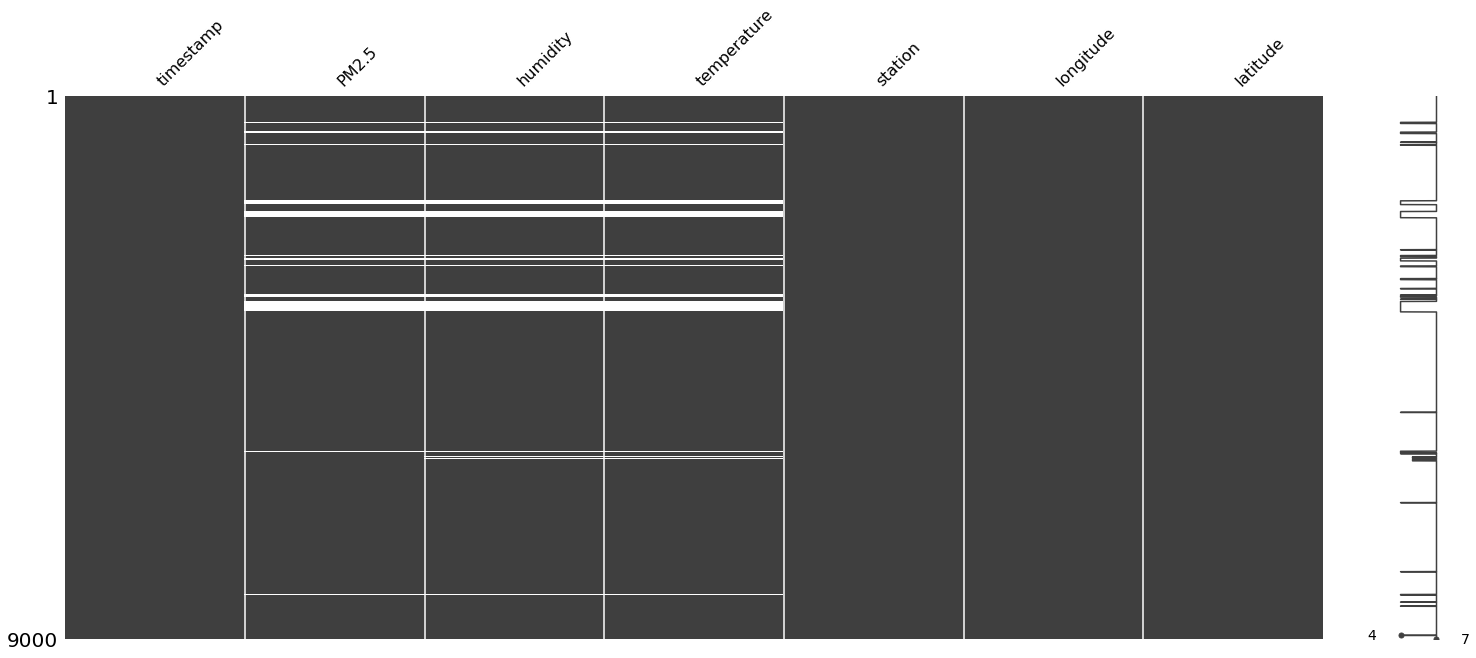

In [26]:
sorted_timestamp_df_HangTrong = df_HangTrong.sort_values(by=['timestamp'])
msno.matrix(sorted_timestamp_df_HangTrong)

In [27]:
missing_values= missing_values_table(df_BaTrieu)
missing_values.style.background_gradient(cmap='Reds')

Data của trạm S0000370-Ba Trieu


,Missing Values,% of Total Values
PM2.5,1937,21.500000
humidity,1929,21.400000
temperature,1929,21.400000


<AxesSubplot:>

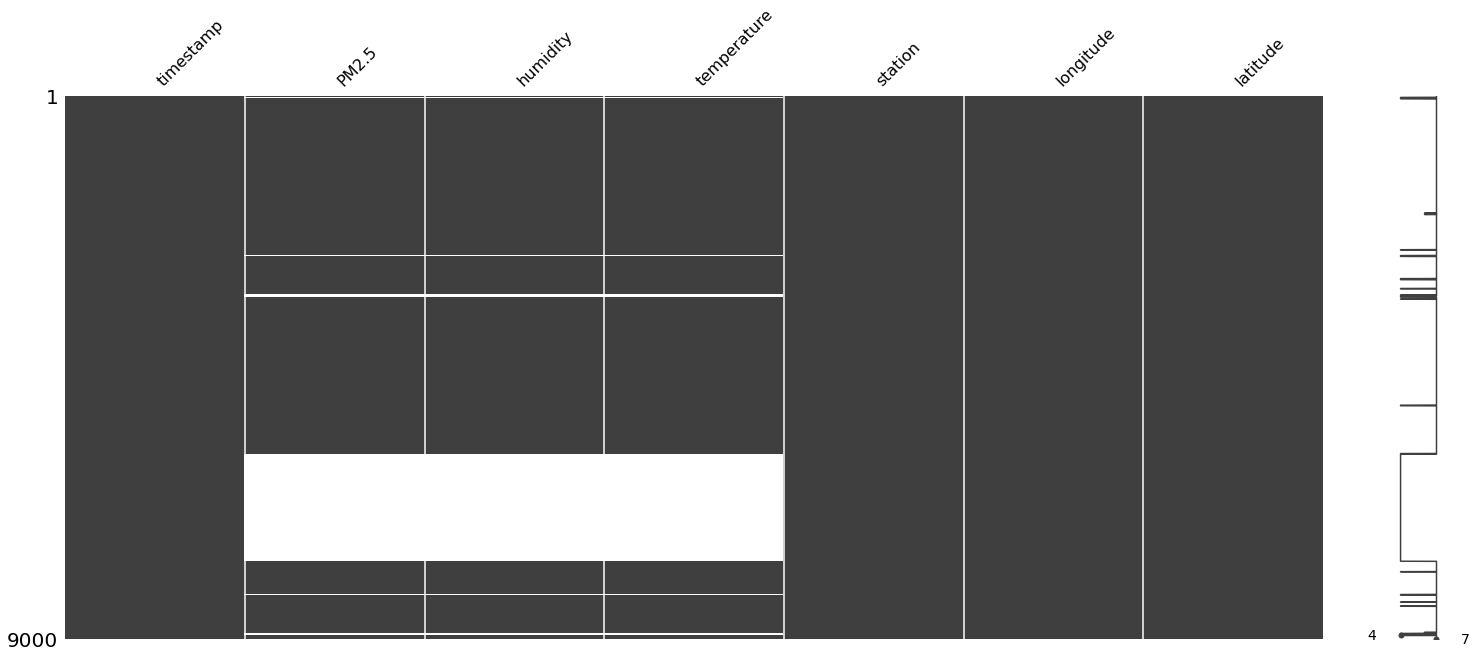

In [28]:
sorted_timestamp_df_BaTrieu= df_BaTrieu.sort_values(by=['timestamp'])
msno.matrix(sorted_timestamp_df_BaTrieu)

=> Dữ liệu bị thiếu nhiều, thường là bị thiếu theo nhiều ngày liên tục

### 1.2.2. Plot vị trí trạm lên bản đồ

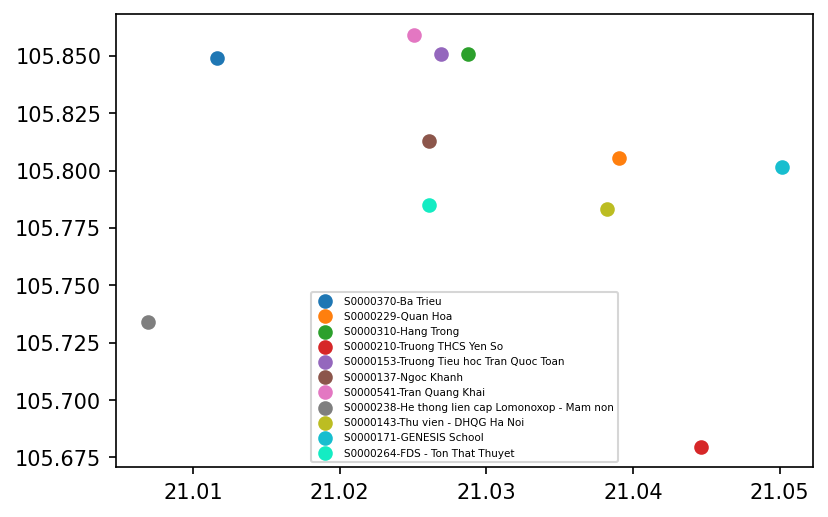

In [29]:
from cProfile import label

fig = plt.figure(dpi=150)

color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',\
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#14ecc3']

for i in range(len(location_input_data)):
    plt.scatter(x=location_input_data.iloc[i]['latitude'],\
         y=location_input_data.iloc[i]['longitude'], label=location_input_data.iloc[i]['station'], color=color_list[i])

plt.legend(prop={'size': 5})
plt.show()

### 1.2.3. Điền giá trị thiếu cho từng trạm
Điền giá trị thiếu bằng **Linear interpolation** cho 2 cột PM2.5 và humidity của từng trạm.

In [30]:
list_of_sorted_df = [sorted_timestamp_df_NgocKhanh, sorted_timestamp_df_BaTrieu,\
     sorted_timestamp_df_Genesis, sorted_timestamp_df_HangTrong, sorted_timestamp_df_Lomonoxop,\
         sorted_timestamp_df_QuanHoa, sorted_timestamp_df_TranQuocToan, sorted_timestamp_df_ThuVien,\
                 sorted_timestamp_df_TonThatThuyet, sorted_timestamp_df_YenSo]

In [31]:
for df in list_of_sorted_df:
    for metric in ["PM2.5", "humidity"]:
        df[metric].interpolate(limit_direction="both",inplace=True)

Điền giá trị thiếu cho các trạm thiếu thông tin temperature bằng temperature của trạm gần nhất với trạm đó

In [32]:
"""Scale tọa độ và tạo ma trận khoảng cách
"""
from sklearn import preprocessing
from scipy.spatial import distance_matrix

min_max_scaler = preprocessing.MinMaxScaler()
location_input_data_scaled = min_max_scaler.fit_transform(location_input_data.iloc[:,1:3])
location_input_data_scaled = pd.DataFrame(location_input_data_scaled, columns=["longitude", "latitude"], index=location_input_data["station"])

location_distance_matrix = pd.DataFrame(distance_matrix(location_input_data_scaled.values, location_input_data_scaled.values),\
     index=location_input_data_scaled.index, columns=location_input_data_scaled.index)


In [33]:
"""Điền giá trị temperature 
"""
for df in list_of_sorted_df:
    this_df_station = df["station"].iloc[0]
    other_station_list = location_distance_matrix[[this_df_station]].drop(index=this_df_station).sort_values(by=this_df_station)
    nearest_station = other_station_list.idxmin().iloc[0]
    for other_df in list_of_sorted_df:
        if other_df["station"].iloc[0] == nearest_station:
            df["temperature"] = np.where(df["temperature"].isnull(), other_df["temperature"], df["temperature"])
        if other_df["station"].iloc[0] == this_df_station:
            continue
        other_station_list = other_station_list.drop(other_df["station"].iloc[0])
        nearest_station = other_station_list.idxmin().iloc[0]

for df in list_of_sorted_df:
    df["temperature"].interpolate(limit_direction="both",inplace=True)


In [34]:
sorted_timestamp_df_NgocKhanh, sorted_timestamp_df_BaTrieu,\
     sorted_timestamp_df_Genesis, sorted_timestamp_df_HangTrong, sorted_timestamp_df_Lomonoxop,\
         sorted_timestamp_df_QuanHoa, sorted_timestamp_df_TranQuocToan, sorted_timestamp_df_ThuVien,\
                 sorted_timestamp_df_TonThatThuyet, sorted_timestamp_df_YenSo = list_of_sorted_df

## 1.3. Đo sự tương quan giữa các thuộc tính

<AxesSubplot:>

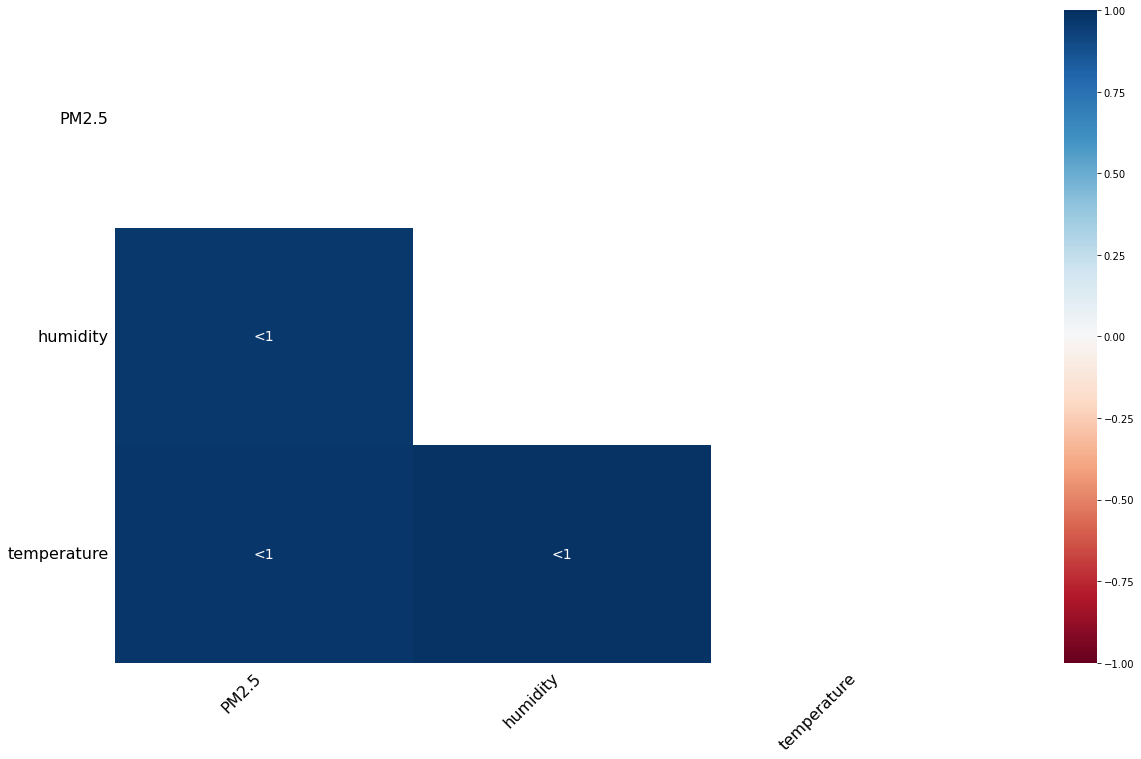

In [35]:
msno.heatmap(sorted_timestamp_df)

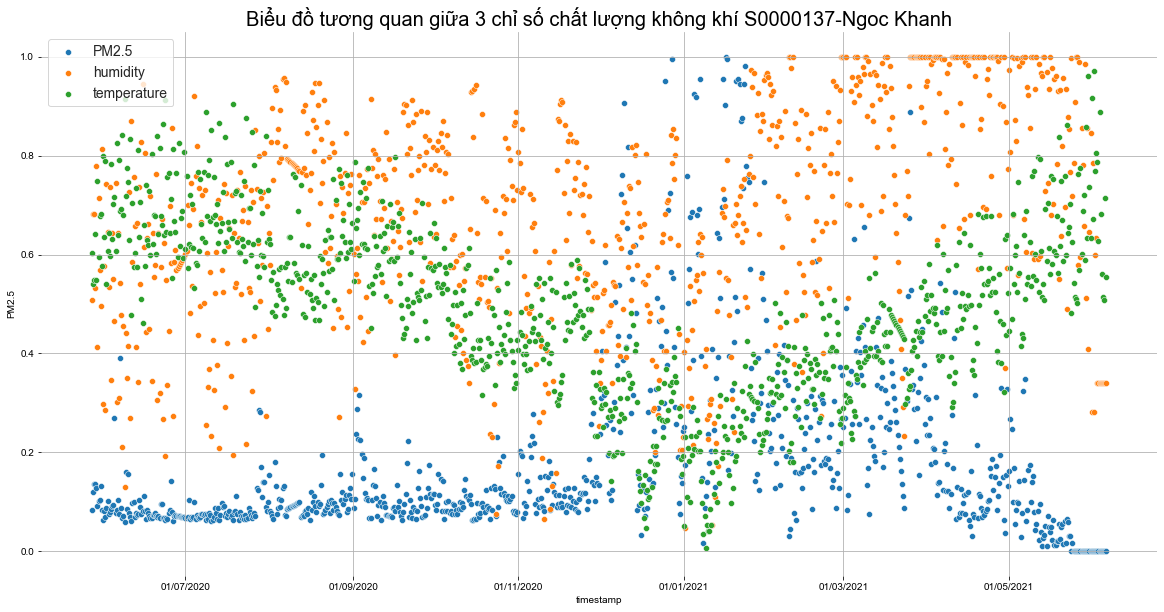

In [36]:
"""Scale Air quality 
"""

import pandas as pd
from sklearn import preprocessing

def visualize_data_correlation(df, iloc_freq):

    x = df.iloc[:,1:4]  
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    scaled_all_input_data = pd.DataFrame(x_scaled, columns=["PM2.5", "humidity", "temperature"])
    scaled_all_input_data["timestamp"] = df["timestamp"].reset_index(drop=True)

    fig,ax = plt.subplots(figsize=(20, 10))
    sns.despine(fig, left=True, bottom=True)
    sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 3})
    sns.set_style("whitegrid", {"axes.grid": False})

    palette = sns.color_palette("tab10")

    sns.scatterplot(x="timestamp", y="PM2.5", data=scaled_all_input_data.iloc[::iloc_freq], label = 'PM2.5', palette=palette)
    sns.scatterplot(x="timestamp", y="humidity", data=scaled_all_input_data.iloc[::iloc_freq], label = 'humidity', palette=palette)
    sns.scatterplot(x="timestamp", y="temperature", data=scaled_all_input_data.iloc[::iloc_freq], label = 'temperature', palette=palette)

    plt.grid() 
    plt.rcParams["xtick.labelsize"] = 14

    if len(df["station"].unique()) == 1:
        station = df["station"].unique()[0]
    else:
        station = "Tất cả các trạm"

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    ax.set_title(f'Biểu đồ tương quan giữa 3 chỉ số chất lượng không khí {station}', fontsize=20)
    ax.legend(fontsize = 14)

visualize_data_correlation(sorted_timestamp_df_NgocKhanh, iloc_freq=10)

## 1.4. Các chỉ số không khí của các trạm theo thời gian

In [37]:
print("Min                  ->  Max timeseries")
print(sorted_timestamp_df['timestamp'].min(), " -> ",  sorted_timestamp_df['timestamp'].max())

Min                  ->  Max timeseries
2020-05-27 12:00:00  ->  2021-06-06 11:00:00


### 1.4.1 Chỉ số PM2.5 của các trạm theo thời gian

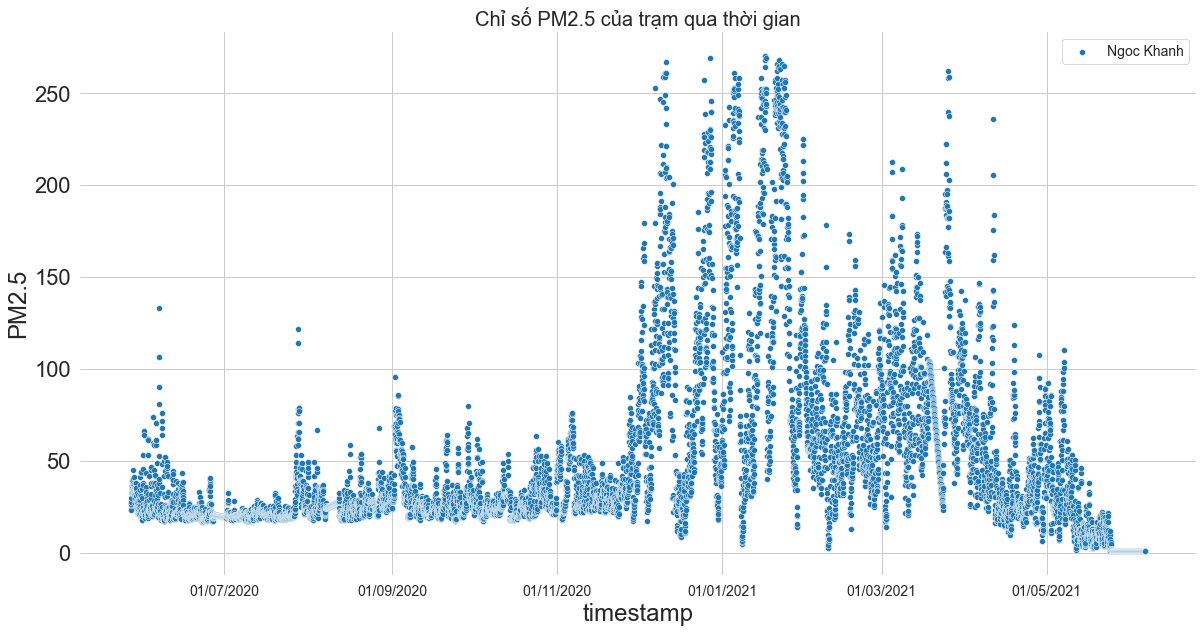

In [38]:
fig,ax = plt.subplots(figsize=(20, 10))
sns.despine(fig, left=True, bottom=True)
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 3})
sns.set_style("whitegrid", {"axes.grid": False})

frequency = 1
palette = sns.color_palette("tab10")

sns.scatterplot(x="timestamp", y="PM2.5", data=sorted_timestamp_df_NgocKhanh.iloc[::frequency], label = 'Ngoc Khanh', palette=palette)
# sns.scatterplot(x="timestamp", y="PM2.5", data=sorted_timestamp_df_ThuVien.iloc[::frequency], label = 'Thu vien - DHQG Ha Noi', palette=palette)
# sns.scatterplot(x="timestamp", y="PM2.5", data=sorted_timestamp_df_TranQuocToan.iloc[::frequency], label = 'Truong Tieu hoc Tran Quoc Toan', palette=palette)
# sns.scatterplot(x="timestamp", y="PM2.5", data=sorted_timestamp_df_Genesis.iloc[::frequency], label = 'GENESIS School', palette=palette)
# sns.scatterplot(x="timestamp", y="PM2.5", data=sorted_timestamp_df_YenSo.iloc[::frequency], label = 'Yen So', palette=palette)
# sns.scatterplot(x="timestamp", y="PM2.5", data=sorted_timestamp_df_QuanHoa.iloc[::frequency], label = 'Quan Hoa', palette=palette)
# sns.scatterplot(x="timestamp", y="PM2.5", data=sorted_timestamp_df_Lomonoxop.iloc[::frequency], label = 'Lomonoxop', palette=palette)
# sns.scatterplot(x="timestamp", y="PM2.5", data=sorted_timestamp_df_TonThatThuyet.iloc[::frequency], label = 'Ton That Thuyet', palette=palette)
# sns.scatterplot(x="timestamp", y="PM2.5", data=sorted_timestamp_df_HangTrong.iloc[::frequency],  label = 'Hang Trong', palette=palette)
# sns.scatterplot(x="timestamp", y="PM2.5", data=sorted_timestamp_df_BaTrieu.iloc[::frequency],  label = 'Ba Trieu', palette=palette)

plt.rcParams["xtick.labelsize"] = 15
plt.grid()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
             
ax.set_title('Chỉ số PM2.5 của trạm qua thời gian', fontsize=20)
ax.legend(fontsize = 14)

In [39]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def visualize_pivot_of_station_through_time(sorted_df, value: str):
      value_pivot_sorted_timestamp_df = sorted_df.pivot(index='timestamp', columns='station', values=value)
      value_pivot_sorted_timestamp_df.fillna(method='bfill',inplace=True)

      fig = make_subplots(
      rows=len(station_list), cols=1,

      subplot_titles=tuple([station for station in station_list]))

      for idx, station in enumerate(station_list):
            fig.add_trace(go.Bar(x=value_pivot_sorted_timestamp_df.index, y=value_pivot_sorted_timestamp_df[station],
                              marker=dict(color=value_pivot_sorted_timestamp_df[station],coloraxis="coloraxis")),
                        idx + 1, 1)

      fig.update_layout(coloraxis=dict(colorscale='Temps'),showlegend=False, title_text=f"{value} của các trạm qua thời gian!")
      fig.update_layout(plot_bgcolor='white')

      fig.update_layout( width=2400,height=2400,shapes=[
            dict(
                  type= 'line',
                  yref= 'paper', y0= 0, y1= 0,
                  xref= 'x', x0=sorted_timestamp_df['timestamp'].min().date(), x1=sorted_timestamp_df['timestamp'].max().date()
      )
      ])

      fig.write_image(f"{value}_stations_through_time.png", format='png')


# visualize_pivot_of_station_through_time(sorted_timestamp_df, value="humidity")
# visualize_pivot_of_station_through_time(sorted_timestamp_df, value="PM2.5")
# visualize_pivot_of_station_through_time(sorted_timestamp_df, value="temperature")   

=> Ba chỉ số này có độ tương quan cao với nhau: 

Keynote về PM2.5:

### 1.4.2. Chỉ số humidity của các trạm qua thời gian

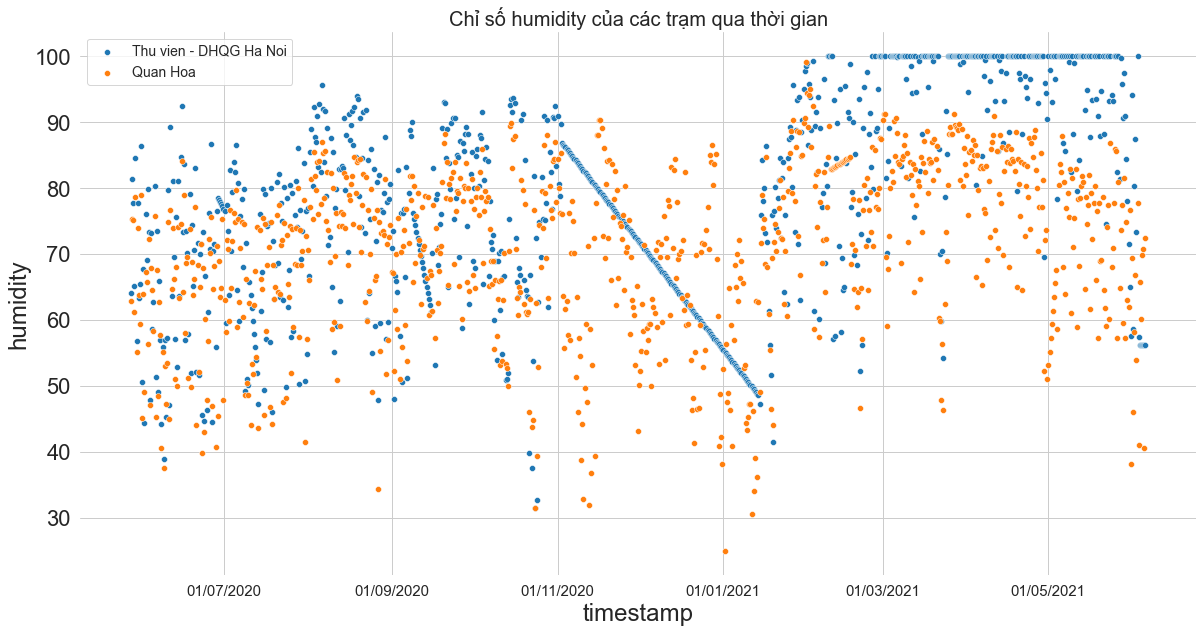

In [40]:
fig,ax = plt.subplots(figsize=(20, 10))
sns.despine(fig, left=True, bottom=True)
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 3})
sns.set_style("whitegrid", {"axes.grid": False})

frequency = 10
palette = sns.color_palette("tab10")

# sns.scatterplot(x="timestamp", y="humidity", data=sorted_timestamp_df_NgocKhanh.iloc[::frequency], label = 'Ngoc Khanh', palette=palette)
sns.scatterplot(x="timestamp", y="humidity", data=sorted_timestamp_df_ThuVien.iloc[::frequency], label = 'Thu vien - DHQG Ha Noi', palette=palette)
# sns.scatterplot(x="timestamp", y="humidity", data=sorted_timestamp_df_TranQuocToan.iloc[::frequency], label = 'Truong Tieu hoc Tran Quoc Toan', palette=palette)
# sns.scatterplot(x="timestamp", y="humidity", data=sorted_timestamp_df_Genesis.iloc[::frequency], label = 'GENESIS School', palette=palette)
# sns.scatterplot(x="timestamp", y="humidity", data=sorted_timestamp_df_YenSo.iloc[::frequency], label = 'Yen So', palette=palette)
sns.scatterplot(x="timestamp", y="humidity", data=sorted_timestamp_df_QuanHoa.iloc[::frequency], label = 'Quan Hoa', palette=palette)
# sns.scatterplot(x="timestamp", y="humidity", data=sorted_timestamp_df_Lomonoxop.iloc[::frequency], label = 'Lomonoxop', palette=palette)
# sns.scatterplot(x="timestamp", y="humidity", data=sorted_timestamp_df_TonThatThuyet.iloc[::frequency], label = 'Ton That Thuyet', palette=palette)
# sns.scatterplot(x="timestamp", y="humidity", data=sorted_timestamp_df_HangTrong.iloc[::frequency],  label = 'Hang Trong', palette=palette)
# sns.scatterplot(x="timestamp", y="humidity", data=sorted_timestamp_df_BaTrieu.iloc[::frequency],  label = 'Ba Trieu', palette=palette)

plt.rcParams["xtick.labelsize"] = 15
plt.grid()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))

ax.set_title('Chỉ số humidity của các trạm qua thời gian', fontsize=20)
ax.legend(fontsize = 14)

### 1.4.3. Chỉ số temperature của các trạm qua thời gian

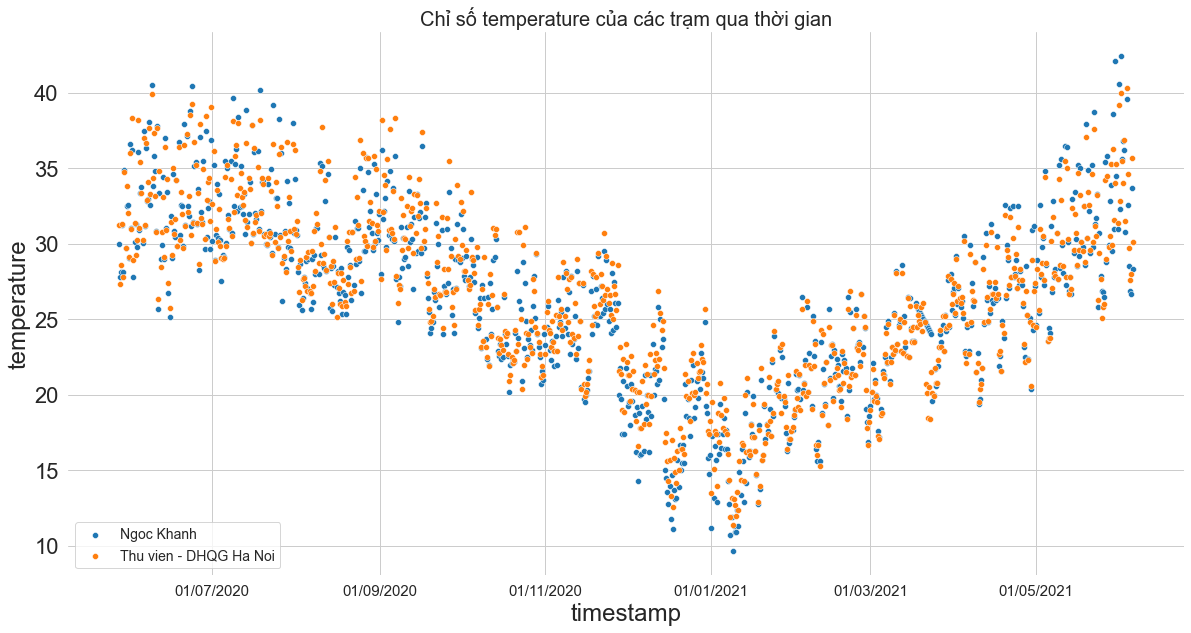

In [41]:
fig,ax = plt.subplots(figsize=(20, 10))
sns.despine(fig, left=True, bottom=True)
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 3})
sns.set_style("whitegrid", {"axes.grid": False})

frequency = 10
palette = sns.color_palette("tab10")

sns.scatterplot(x="timestamp", y="temperature", data=sorted_timestamp_df_NgocKhanh.iloc[::frequency], label = 'Ngoc Khanh', palette=palette)
sns.scatterplot(x="timestamp", y="temperature", data=sorted_timestamp_df_ThuVien.iloc[::frequency], label = 'Thu vien - DHQG Ha Noi', palette=palette)
# sns.scatterplot(x="timestamp", y="temperature", data=sorted_timestamp_df_TranQuocToan.iloc[::frequency], label = 'Truong Tieu hoc Tran Quoc Toan', palette=palette)
# sns.scatterplot(x="timestamp", y="temperature", data=sorted_timestamp_df_Genesis.iloc[::frequency], label = 'GENESIS School', palette=palette)
# sns.scatterplot(x="timestamp", y="temperature", data=sorted_timestamp_df_YenSo.iloc[::frequency], label = 'Yen So', palette=palette)
# sns.scatterplot(x="timestamp", y="temperature", data=sorted_timestamp_df_QuanHoa.iloc[::frequency], label = 'Quan Hoa', palette=palette)
# sns.scatterplot(x="timestamp", y="temperature", data=sorted_timestamp_df_Lomonoxop.iloc[::frequency], label = 'Lomonoxop', palette=palette)
# sns.scatterplot(x="timestamp", y="temperature", data=sorted_timestamp_df_TonThatThuyet.iloc[::frequency], label = 'Ton That Thuyet', palette=palette)
# sns.scatterplot(x="timestamp", y="temperature", data=sorted_timestamp_df_HangTrong.iloc[::frequency],  label = 'Hang Trong', palette=palette)
# sns.scatterplot(x="timestamp", y="temperature", data=sorted_timestamp_df_BaTrieu.iloc[::frequency],  label = 'Ba Trieu', palette=palette)

plt.rcParams["xtick.labelsize"] = 15
plt.grid()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))

ax.set_title('Chỉ số temperature của các trạm qua thời gian', fontsize=20)
ax.legend(fontsize = 14)

## 1.5. XGBoost Time-series

In [42]:
min_max_scaler = preprocessing.MinMaxScaler()

def merge_scale_df(list_or_df):
    if isinstance(list_or_df, list):
        df = pd.concat(list_or_df, ignore_index=True)
    else:
        df = list_or_df
    
    result_df = pd.DataFrame(columns=["PM2.5", "humidity", "temperature", "longitude", "latitude"])

    result_df['timestamp'] = df['timestamp']
    result_df['station'] = df['station']
    result_df['humidity'] = min_max_scaler.fit_transform(df['humidity'].values.reshape(-1, 1))
    result_df['temperature'] = min_max_scaler.fit_transform(df['temperature'].values.reshape(-1, 1))
    result_df['PM2.5'] = min_max_scaler.fit_transform(df['PM2.5'].values.reshape(-1, 1))

    longitude_latitude_df = pd.DataFrame(min_max_scaler.fit_transform(df.iloc[:,-2:]), columns=["longitude", "latitude"])
    result_df['longitude'] = longitude_latitude_df['longitude']
    result_df['latitude'] = longitude_latitude_df['latitude']

    result_df = result_df.set_index('timestamp')

    return result_df

In [43]:
df_NgocKhanh = merge_scale_df(sorted_timestamp_df_NgocKhanh).sort_index()
df_NgocKhanh.drop('station', axis=1, inplace=True)

In [44]:
def split_data(data, split_date):
    train_data = data[data.index <= split_date].copy()
    test_data = data[data.index >  split_date].copy()

    train_label = train_data['PM2.5']
    test_label = test_data['PM2.5']

    train_data.drop('PM2.5', axis=1, inplace=True)
    test_data.drop('PM2.5', axis=1, inplace=True)

    return train_data, train_label, test_data, test_label


X_train, y_train, X_test, y_test = split_data(df_NgocKhanh, '2021-04-10 00:00:00')


In [45]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False)

c:\Users\ASUS\anaconda3_2\envs\weatherforcast\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

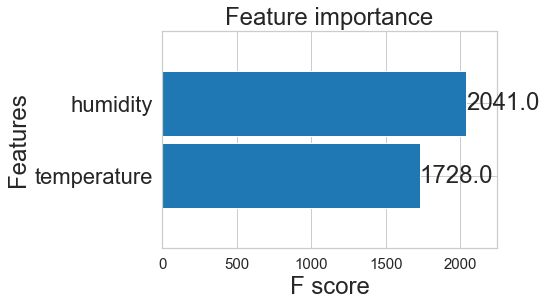

In [46]:
xgb.plot_importance(reg, height=0.9)